# Tubes de confiance

Les tubes de confiances sont calculés à partir d'estimations de chacune des courbes en fonction d'autres appelés "facteurs".

Ce code permet de construire des tubes graphiquement. Pour l'instant l'outil utilisé est assez simple puisqu'il n'utilise que des régressions linéaires. L'idée est que de telles régressions sur de petits nombres de facteurs doivent être suffisante sur des intervalles pas trop longs.

Les régressions sont calculées à partir d'échantillonnage de points et testées sur d'autres échantillonnages différents. Un paramètre permet de choisir le taux d'échantillonnage pour l'apprentissage et le test.

On construit ainsi pour chaque variable à étudier une série de petites régressions. Les tubes sont simplement issus des valeurs maximales et minimales de ces régressions.

Un objet `Tube` gère l'apprentissage et la conception graphique de tous les tubes d'un intervalle, et un autre objet  `AppTube` applique le tube à un Opset compatible (ayant les mêmes variables par signal).

### Reste à faire :

1. [ ] Un calcul de valeurs extrêmes pour appliquer un coefficient à ces bornes pour que le score (actuellement nombre de points en dehors du tube) corresponde à un seuil statistique.
2. [ ] L'implémentation des scores dans l'objet d'application.


In [77]:
from importlib import reload

import numpy as np
import pandas as pd
import tabata.opset as op
import tabata.instants as instants
import tabata.tubes as tubes

On récupère les deux détections d'instants effectuées dans le notebook "instants_doc".

In [78]:
import pickle
with open('data/out/interval.pkl','rb') as pkl:
    S,S1 = pickle.load(pkl)

### `S` correspond au début de la phase de croisère.

In [79]:
S

OPSET 'data/out/AFL1EB_C.h5' de 48 signaux.
        position courante : sigpos  = 12
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 7 instant(s) sélectionnés parmis 10 courbes observées et 1 variables.

In [80]:
S.plot()

### `S1` est la fin de la phase de croisière.

In [81]:
S1

OPSET 'data/out/AFL1EB_C.h5' de 48 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 16 instant(s) sélectionnés parmis 48 courbes observées et 1 variables.

In [82]:
S1.plot()

## Extraction de l'intervalle

On utilise la méthode `between()` du détecteur d'instants pour extraire la zone à étudier.

_(Une autre solution sans doite plus maline aurait été d'utiliser la méthode `right()` sur `S` puis extraire `S1` à partir de la première détection et enfin utiliser `left()` sur `S1`.)_

In [83]:
E = S.between(S,S1)

In [84]:
E.plot()

### Mise en évidence d'une partie d'un signal.

Les Opsets ont la possibilité de définir une variable booléenne comme une _phase_ particulière. La fonction `highlight()` du package "tubes" permet de fixer une phase INTERVAL à un OPset à partir d'un autre.

_(Il est nécessaire que les deux Opsets aient les mêmes noms d'entregistrements.)_

In [85]:
ds = tubes.highlight(S,E)

In [86]:
ds.plot()

## Construction d'un tube

Un tube est un couple de deux courbes qui devraint délimiter les zônes acceptables pour un signal. Pour construire nos tubes nous utilisons une populatuon de régressions. Ces régressions seront appliquées à de petits nombres de facteurs et apprises sur un échantillonnage des points.

Les maximum et minimum de ces rgressions vont donner un gabarit au tube. On appliquera finalement à ce gabarit un facteur multiplicatif.

In [87]:
reload(tubes)

<module 'tabata.tubes' from 'H:\\wrk\\_jlpath\\tabata\\tubes.py'>

### Variables et facteurs

Nous ne calculons de tubes que pour les variables sélectionnées dans l'ensemble défini par la variable `.variables`.
Les facteurs exploités par les régressions sont à prendre dans `.factors`.

Par défaut seule la première variable des signaux ne sera exploitée et toutes les autres serviront de facteurs.

In [88]:
T = tubes.Tube(E.storename)
T.variables = {"ALT[m]", "Tisa[K]"}
T.fit()

OPSET 'data/out/AFL1EB_CB.h5' de 48 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
TUBE : on 2 variables.

La description du tube donne le détail des apprentissages.

In [89]:
T.describe()

,ALT[m],Tisa[K],TAS[m/s],Vz[m/s],Masse[kg],F[N],CR,TIME,MEDIAN,CAUSAL
Regresions,,,,,,,,,,
Tisa[K],5,0,5,2,4,3,4,0,0,0
ALT[m],0,4,4,4,3,3,5,0,0,0


Ce DataFrame dispose de lignes correspondant chacune à un modèle et les ciolonnes comptabilisent le nombre de fois qu'un facteur est utilisé.

### Paramétrage de l'apprentissage

Les paramètres de l'apprentissage sont stockés dans le dictionnaire `.learn_params`.

In [90]:
T.learn_params

{'retry_number': 10,
 'keep_best_number': 5,
 'samples_percent': 0.01,
 'max_features': 5}

le nombre de régressions testées par modèle est défini par `retry_number` mais au final seules les meilleures `keep_best_number` seront conservées en fonction de leur coefficient $R^2$.

Les deux autres paramètres, `samples_percent` donne le taux d'échantillonnage por l'apprentissage et le test, `max_features`, le nombre maximum de facteurs utilisables par régression.

### Facteurs supplémentaires
Il est possible de rajouter des facteurs supplémentaires. 
En fait, à terme il derait être possible de construire des modèles plus complexes, par exemple en rajoutant des interactions. Mais pour l'instant seuls deux facteurs supplémentaires sont sélectionnables.

Ils sont définis par le dictionnaire `.feature_params`.

In [91]:
T.feature_params

{'local_value': 'Absolute', 'use_time': 'No'}

`local_value` peut prendre l'une des trois valeurs :
- 'Absolute' (par défaut) correspond à ne pas rajouter de variable supplémentaire.
- 'Median' rajoute la variable 'MEDIAN' constante égale à la médiane du signal à modéliser (pour avoir une estimation relative de l'écart à la médiane).
- 'Causal' rajoute une variable 'CAUSAL' constante égale à la première valeur du signal à prédire

`use_time` peut prendre l'une des deux valeurs :
- 'No' (par défaut) consiste à ne rien ajouter au signal.
- 'Yes' permet d'ajouter une variable 'TIME' correspondant aux numéro de chaque point de la courbe.

### Gabarit du tube

Pour l'instant le gabrit du tube est fixé "à la main" par l'élément `tube_factor` du dictionnaire `.tube_params`.

In [92]:
T.tube_params

{'tube_factor': 10.0, 'filter_width': 20}

A terme il va falloir remplacer cette valeur par une proportion des points du signal que l'on suppose hors-tube. Le mieux étant d'estimer une loi de pareto généralisée au delà du tube pour identifier une vrai probabilité d'anomalie (à faire).

Une autre valeur de ce dictionnaire: `filter_width` permet de lisser le tube.

## Estimation et scores

La méthode `estimate()` permet de récupérer les bornes du tube et la valeur moyenne pour une variable sous la forme de trois vecteurs.

Trois fonctions calculent les scores correspondant aux nombre de points hors-tube. A chaque fois, un DataFrame de résultats est renvoyé.

In [93]:
z,zmin,zmax = T.rewind(3).estimate("ALT[m]")

`local_scores()` renvoie les scores de l'enregistrement courant.
La première colonne est le nombre de points de l'enregistrement, et chaque colonne suivante donne le nombre de points "hors-tube".

In [94]:
T.local_scores()

,N,Tisa[K],ALT[m]
/record_03,2104,3,0


`scores()` calcule tous les scores de l'Opset. La première colonne correspond au nombre de point du signal.

In [95]:
T.scores()

,N,Tisa[K],ALT[m]
/record_00,3606,46,0
/record_01,3335,4,2
/record_02,3045,2,0
/record_03,2104,3,0
/record_04,734,0,0
/record_05,323,2,0
/record_10,373,66,0
/record_11,3312,1,0
/record_12,2416,1,0
/record_13,2754,87,37


Finalement `plot_scores()` donne les résultats de manière graphique. après calcul de la proportion de poinst "hors-tube" par signal.

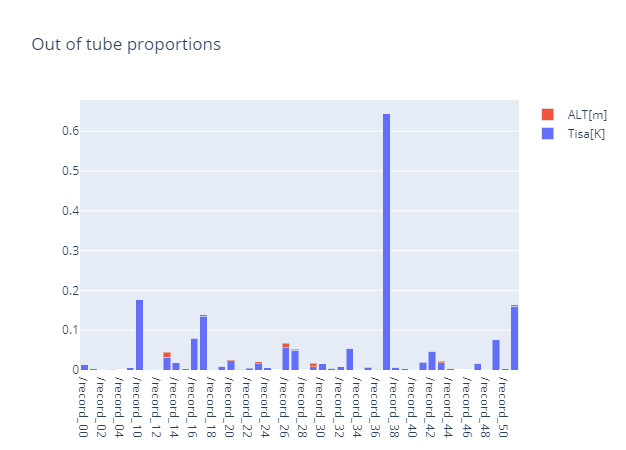

In [96]:
T.plot_scores()

## Interactivité des tubes

Les tubes ont une interface interactives comme les `Selector` et les `Opset`. Elle est obtenue par la méthode `.plot()`.

In [97]:
T.plot()

Trois onglets sont accessibles :
- **Plot** est l'affichage standard des Opsets sur lequel est rajouté le tube en vert pâle.
- **Param** donne un accès interactif à l'ensemble des parmètres du tube.
- **Learn** permet de relancer un apprentissage.

### Relancer un apprentissage interactivement.

L'onglet **Learn** permet de sélectionner des variables et des facteurs pour un nouvel apprentissage. Les anciens apprentissages sont soit gardés, soit remplacés. Cela permet de spécifier des apprentissages spécifiques par variable.

## Réintégrer un tube sur l'Opset initial.

Un objet applicatif `AppTube` permet de superposer un tube local à un Opset initial.

_(Il faut bien sur que l'Opset initial et le tube soient compatibles comme pour la fonction `tubes.highlight()`.

In [98]:
A = tubes.AppTube(S,T)
A.plot()

_Jérôme Lacaille (YOR)_